# Perform analyses of 300-member prior/truth reconstructions.

In [1]:
# put the directory path to your LMR repository here
import sys
sys.path.append("/Users/dan/Desktop/LMR_py3/")
#!cd /Users/dan/Desktop/LMR_py3

# prefix for figure filename
#fig_prefix='prior_truth_'

In [2]:
import os
os.chdir('/Users/dan/Desktop/LMR_py3')
import LMR_lite_utils as LMRlite
import LMR_utils
import LMR_config
import numpy as np
import os,sys
from time import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns


Loading information from datasets.yml
Loading information from grid_def.yml


# Define routines for processing

In [3]:
# Load and interpolate all of the priors I want to use as truth

def mk_ad(lmr_names,model_names):
    
    # Initialize an array of various interpolated model fields
    ad = []

    for ii in np.arange(len(lmr_names)):
        dd = {}
        cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
        yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
        cfg = LMRlite.load_config(yaml_file)

        X, Xb_one = LMRlite.load_prior(cfg)
        Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)

        # check if config is set to regrid the prior
        if cfg.prior.regrid_method:
            print('regridding prior...')
            # this function over-writes X, even if return is given a different name
            [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
        else:
            X.trunc_state_info = X.full_state_info

        Xb_one = Xb_one_new
        Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)

        dd['X']            = X
        dd['Xbp']          = Xbp
        dd['name']         = model_names[ii]
        dd['lmr_name']     = lmr_names[ii]
        dd['grid']         = LMRlite.Grid(X)
        dd['prox_manager'] = LMRlite.load_proxies(cfg)
        dd['numprox']      = len(LMRlite.load_proxies(cfg).all_proxies) 

        print(ii)
        print(dd['name'])

        ad.append(dd)
        
    return ad

In [4]:
def mk_yes(X,Xbp,prox_manager,grid):
    
    [_,nens] = Xbp.shape
    numprox = len(prox_manager.ind_assim)
    vYe = np.zeros([numprox,nens])
    vYe_coords = np.zeros([numprox,2])

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon
        # the ensemble prior estimates
        vYe[proxy_idx,:] = Xbp[npos,:]
        vYe_coords[proxy_idx,:] = X.coords[npos,:]

    return vYe, vYe_coords

# Define plotting routines

In [155]:
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt


class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))


In [173]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


In [5]:
# Plot RMS error

def plt_var(cdd):
    
    VM = 2.0 # vmax

    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    
    grid = cdd[0]['grid']

    fig = plt.figure(figsize=(16,12))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 3),
                    axes_pad=0.6,
                    cbar_location='right',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    switch_ax = [0, 3, 6, 1, 4, 7, 2, 5, 8]
    
    for jj, ax in enumerate(axgr):
        ii = switch_ax[jj]
        #ii = jj
        rmsc = cdd[ii]['rmse']

        #print(cdd[ii]['prior_name'])
        #print(cdd[jj]['prior_name'])
        
        cldat = rmsc.reshape(grid.nlat,grid.nlon)**2
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[ii])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=VM,vmin=0.,
                        transform=projection,
                        cmap='YlOrRd',
                        )
        #plt.title('Prior:'+cdd[ii]['prior_name']+', Truth:'+cdd[ii]['truth_name'])

        ax.coastlines(color='gray')
        if cdd[ii]['pind']==2:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        if cdd[ii]['tind'] == 0:
            ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)

        #plt.title('Prior: '+ cdd[ii]['prior_name'] + ', truth: ' + cdd[ii]['truth_name'])
        
    cb=axgr.cbar_axes[0].colorbar(p)
    #fig.suptitle(title, fontsize=14)
#    plt.tight_layout
    #plt.show();


In [186]:
# Plot RMS error

def plt_var2(cdd):
    
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    
    grid = cdd[0]['grid']

    fig = plt.figure(figsize=(16,4))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(1, 3),
                    axes_pad=0.6,
                    cbar_location='right',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    tt_ax = [0,4,8]

    for jj, ax in enumerate(axgr):
        rmsc = cdd[tt_ax[jj]]['rmse']

        cldat = rmsc.reshape(grid.nlat,grid.nlon)**2
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[jj])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=2.,vmin=0.,
                        transform=projection,
                        cmap='Reds',
                        )
        plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'] + ', truth: ' + cdd[tt_ax[jj]]['truth_name'])

        ax.coastlines(color='gray')

    cb=axgr.cbar_axes[0].colorbar(p)
    plt.show()
    
    #############

    fig = plt.figure(figsize=(16,8))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(2, 3),
                    axes_pad=0.6,
                    cbar_location='right',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    ntt_ax = [1,2,3,5,6,7]
    ntt_ax = [1,3,6,2,5,7]
    tt_eq  = [0,4,8,0,4,8]
    
    vmin = -2.0
    vmax = 2.0

    cmap = 'RdBu_r' 
    
    for jj, ax in enumerate(axgr):
        rmsc = cdd[ntt_ax[jj]]['rmse']
        rt   = cdd[tt_eq[jj]]['rmse']
        
        cldat = rmsc.reshape(grid.nlat,grid.nlon)**2-rt.reshape(grid.nlat,grid.nlon)**2
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[jj])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=vmax,vmin=vmin,
                        transform=projection,
                        cmap='RdBu_r'
                        )
        plt.title('Prior: '+ cdd[ntt_ax[jj]]['prior_name'] + ', truth: ' + cdd[ntt_ax[jj]]['truth_name'] +
                  '\n minus Prior: '+ cdd[tt_eq[jj]]['prior_name'] + ', truth: ' + cdd[tt_eq[jj]]['truth_name'])
        
        ax.coastlines(color='gray')

    cb=axgr.cbar_axes[0].colorbar(p)

In [241]:
# Plot noise to signal ratios (variance)

def plt_n2s(cdd,Xd):
    
    VM = 1.5
    
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    
    grid = cdd[0]['grid']


    # Compute mean truth variances over 3 realizations each
    key = np.array([[0,1,2],[3,4,5],[6,7,8]])
    tvar = np.zeros([3,91*180])*np.nan
    for ii in np.arange(3):
        tvar[ii,:] = np.mean(np.var(Xd[key[ii,:],:,:],2),0)
    
    fig = plt.figure(figsize=(16,4))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(1, 3),
                    axes_pad=0.6,
                    cbar_location='right',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    tt_ax = [0,4,8]

    for jj, ax in enumerate(axgr):
        evar = cdd[tt_ax[jj]]['rmse']
        
        cldat = (evar/tvar[jj,:]**.5).reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[jj])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=VM,vmin=0.,
                        transform=projection,
                        cmap='Reds',
                        )
        plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'] + ', truth: ' + cdd[tt_ax[jj]]['truth_name'])

        ax.coastlines(color='gray')

    cb=axgr.cbar_axes[0].colorbar(p)
    plt.show()
    
    #############

    fig = plt.figure(figsize=(16,8))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(2, 3),
                    axes_pad=0.6,
                    cbar_location='right',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    ntt_ax = [1,3,6,2,5,7]
    # Indices of truth experiments
    tt_eq  = [0,4,8,0,4,8]
    tvari  = [0,1,2,0,1,2]
    
    vmin = -1.0
    vmax = 1.0

    cmap = 'RdBu_r' 
    
    for jj, ax in enumerate(axgr):
        rmsc = cdd[ntt_ax[jj]]['rmse']
        rt   = cdd[tt_eq[jj]]['rmse']
        
        cldat = ((rmsc-rt)/tvar[tvari[jj]]).reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[jj])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=VM,vmin=-VM,
                        transform=projection,
                        cmap='RdBu_r'
                        )
        plt.title('Prior: '+ cdd[ntt_ax[jj]]['prior_name'] + ', truth: ' + cdd[ntt_ax[jj]]['truth_name'] +
                  '\n minus Prior: '+ cdd[tt_eq[jj]]['prior_name'] + ', truth: ' + cdd[tt_eq[jj]]['truth_name'])
        
        ax.coastlines(color='gray')

    cb=axgr.cbar_axes[0].colorbar(p)

In [243]:
# Plot fraction of error

def plt_FOE(cdd,Xd):
    
    VM = 1.5
    
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    
    grid = cdd[0]['grid']


    # Compute mean truth variances over 3 realizations each
    key = np.array([[0,1,2],[3,4,5],[6,7,8]])
    tvar = np.zeros([3,91*180])*np.nan
    for ii in np.arange(3):
        tvar[ii,:] = np.mean(np.var(Xd[key[ii,:],:,:],2),0)
    
    fig = plt.figure(figsize=(16,8))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(2, 3),
                    axes_pad=0.6,
                    cbar_location='right',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    ntt_ax = [1,3,6,2,5,7]
    # Indices of truth experiments
    tt_eq  = [0,4,8,0,4,8]
    tvari  = [0,1,2,0,1,2]
    
    vmin = -1.0
    vmax = 1.0

    cmap = 'RdBu_r' 
    
    for jj, ax in enumerate(axgr):
        rmsc = cdd[ntt_ax[jj]]['rmse']
        rt   = cdd[tt_eq[jj]]['rmse']
        
        cldat = ((rmsc**2-rt**2)/rt**2).reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[jj])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=VM,vmin=-VM,
                        transform=projection,
                        cmap='RdBu_r'
                        )
        plt.title('Prior: '+ cdd[ntt_ax[jj]]['prior_name'] + ', truth: ' + cdd[ntt_ax[jj]]['truth_name'] +
                  '\n minus Prior: '+ cdd[tt_eq[jj]]['prior_name'] + ', truth: ' + cdd[tt_eq[jj]]['truth_name'])
        
        ax.coastlines(color='gray')

    cb=axgr.cbar_axes[0].colorbar(p)

In [59]:
# Function to test hypothesis about what sets localization

def mkresplot(ad,obind):

    import LMR_lite_utils as LMRlite
    import LMR_utils
    import LMR_config
    import numpy as np
    import os,sys
    from time import time
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature
    from cartopy.util import add_cyclic_point
    %matplotlib inline
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm
    
    NB = 100
    Nens = 60
    # Pick an ob location

    grid = ad[0]['grid']
    
    # "truth"
    ii = 0
    vYe_t, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],ad[ii]['prox_manager'],ad[ii]['grid'])

    # Make a map of distances (good for both prior and truth)
    var = list(ad[ii]['X'].statevars.keys())[0]
    X_lat = ad[ii]['X'].prior_dict[var]['lat']
    X_lon = ad[ii]['X'].prior_dict[var]['lon']

    # Wrap before computing dists to help with contours below
    X_lonw, wrap_lon = cutil.add_cyclic_point(X_lon, coord=grid.lon[0,:], axis=1)
    X_latw, wrap_lon = cutil.add_cyclic_point(X_lat, coord=grid.lon[0,:], axis=1)
    #distsw = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lonw,X_latw),dtype=np.float64)
    dists = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lon,X_lat),dtype=np.float64)

    # Compute regressions in distance range for two models and save
    # "prior"
    jjj = 1
    vYe_p, vYe_coords = mk_yes(ad[jjj]['X'],ad[jjj]['Xbp'],ad[jjj]['prox_manager'],ad[jjj]['grid'])

    rmap_t = 1/(Nens-1)*ad[ii]['Xbp'].dot(vYe_t[obind,:])/np.var(vYe_t[obind,:])
    rmap_p = 1/(Nens-1)*ad[jjj]['Xbp'].dot(vYe_p[obind,:])/np.var(vYe_p[obind,:])


    # Define a range of distances
    drange = np.linspace(0,20000,NB)

    # Loop through distance ranges
    diffs = (rmap_p-rmap_t)**2#/np.var(vYe_p[obind,:])
    diffs_lat = diffs*np.cos(np.deg2rad(grid.lat.ravel()))
    r2_lat = (np.reshape(diffs_lat,[grid.nlat,grid.nlon]))
    r2 = (np.reshape(diffs,[grid.nlat,grid.nlon]))
    r1 = [] # mean
    rv = [] # var
    for jj in np.arange(len(drange)-1):
        r1.append( np.sum( r2_lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]*np.sin(np.deg2rad(np.abs(grid.lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ])))));
        rv.append( np.var( r2_lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]));

    # Need to normalize by variance!

    import cartopy.util as cutil
    import cartopy.crs as ccrs
    fig = plt.figure(figsize=(8,4))

    r2w, wrap_lon = cutil.add_cyclic_point(r2, coord=grid.lon[0,:], axis=1)
    #distsw, wrap_lon = cutil.add_cyclic_point(dists, coord=grid.lon[0,:], axis=1)

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
    ax.grid(True,which='major',axis='both')
    cs = ax.pcolor(wrap_lon,grid.lat[:,0],r2w/np.max(r2w),cmap='YlOrRd')#,vmin=-5,vmax=1)
    ax.coastlines(color='gray')
    CS=ax.contour(grid.lon[0,:],grid.lat[:,0],dists,10,colors='gray')
    ax.clabel(CS,fmt='%r')
    print(np.max(r2w))

    ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.ylabel(' \n ')

    #sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=plt.Normalize(np.min(r2w),np.max(r2w)))
    #sm._A = []
    #plt.colorbar(sm,ax=ax)
 
    cbar = plt.colorbar(cs, shrink=.9)#, extend='both')
     
    ax.plot(np.mod(vYe_coords[obind,1] - 180.0, 360.0) - 180.0, vYe_coords[obind,0],'k*')
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/reg_error_'+model_names[ii]+'_'+model_names[jjj]+str(obind)+'.pdf')
    plt.tight_layout
    plt.show()

    return drange, r1


In [110]:
def plotswarm(gmp,col):
    si = 15
    fig = plt.figure(figsize=(4,6))
    sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
    ax=sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="truth_name",size=si,marker='.',palette=[col])
    plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000','2000'])
    plt.xlabel('Localization radius (km)')
    plt.xticks(rotation=45,ha="right")
    plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
    handles, labels = ax.get_legend_handles_labels()
    plt.ylim([0.24,0.4])
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.2, .7), loc=2, borderaxespad=0.,frameon=True)
    #plt.tight_layout()
    
    # For final paper figure
    plt.grid()
    ax.legend_.remove()



In [71]:
def plot_reg_swarm(gmp,col):

    sns.set(style='ticks', context='talk')

    si = 15
    fig = plt.figure(figsize=(8,6))
    sns.swarmplot(data=gmp,x="regind", y="errvar", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
    #ax=sns.swarmplot(data=gmp,x="regind", y="errvar", hue="truth_name",size=si,marker='.',palette=[col])
    plt.xticks(np.arange(len(regnames)),regnames,rotation=45,ha="right")
    plt.xlabel('')
    plt.ylabel('Error variance of global, hemispheric, \n and regional spatial means (K$^2$)')
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.25, .75), loc=3, borderaxespad=0.,frameon=True)
    plt.ylim([0,0.25])
    #plt.tight_layout()


In [106]:
def plot_reg_swarm2(gmp,ym):

    sns.set(style='ticks', context='talk')

    si = 15
    fig = plt.figure(figsize=(3,6))
    sns.swarmplot(data=gmp,x="truth_name", y="errvar", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
    ax=sns.swarmplot(data=gmp,x="truth_name", y="errvar", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('Error variance of spatial means (K$^2$)')
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.25, .75), loc=3, borderaxespad=0.,frameon=True)
    plt.ylim([0,ym])
    #plt.tight_layout()
    
    # Plain figures to make the composite for the paper:
    ax.legend_.remove()
    plt.ylabel('')
    plt.yticks()
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
    #plt.tick_params(
    #axis='x',          # changes apply to the x-axis
    #labelbottom=False) # labels along the bottom edge are off
    
    plt.grid()

# Plot variance maps

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


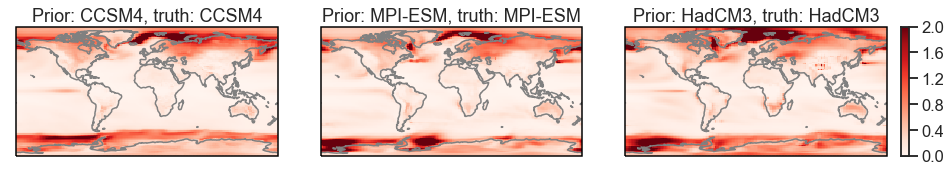

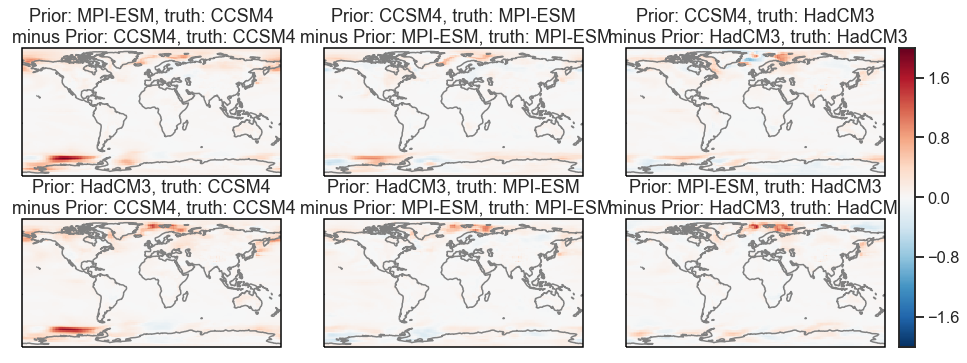

In [187]:
SNR  = 0.4
cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_0.0.npy')
plt_var2(cdd)
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/map_'+str(SNR)+'.png',bbox_inches='tight',dpi=300)


#SNR  = 100.0
#cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_SNR_100.0_locrad_0.0.npy')
#title = 'SNR = '+str(SNR)
#plt_rmse(cdd,title)
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/pt_figs/basic_'+str(SNR)+'.png',bbox_inches='tight',dpi=300)
#plt.show()

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


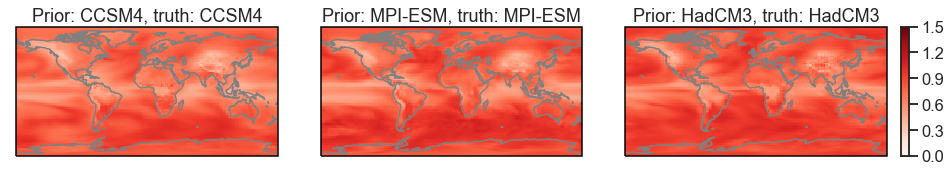

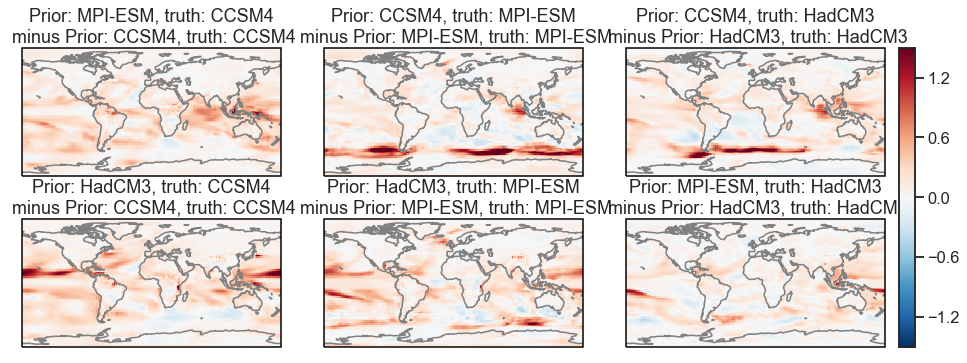

In [242]:
SNR  = 0.4
cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_0.0.npy')
Xd  = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_0.0_ad.npy')
plt_n2s(cdd,Xd)
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/map_'+str(SNR)+'.png',bbox_inches='tight',dpi=300)


#SNR  = 100.0
#cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_SNR_100.0_locrad_0.0.npy')
#title = 'SNR = '+str(SNR)
#plt_rmse(cdd,title)
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/pt_figs/basic_'+str(SNR)+'.png',bbox_inches='tight',dpi=300)
#plt.show()

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


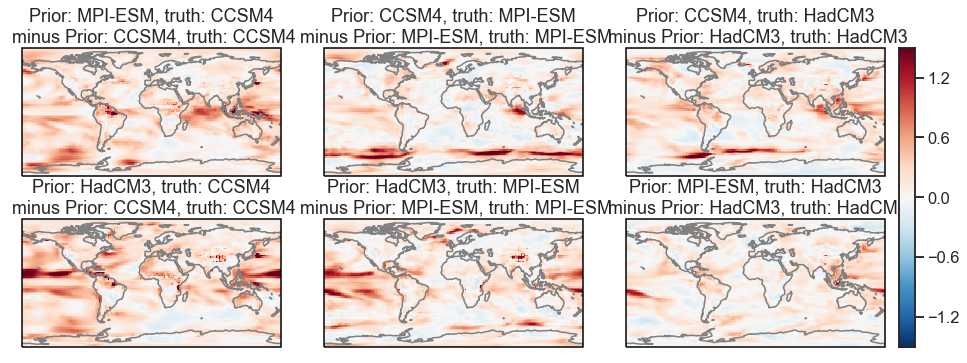

In [251]:
SNR  = 0.4
cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_0.0.npy')
Xd  = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_0.0_ad.npy')
plt_FOE(cdd,Xd)
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/map_'+str(SNR)+'.png',bbox_inches='tight',dpi=300)


#SNR  = 100.0
#cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_SNR_100.0_locrad_0.0.npy')
#title = 'SNR = '+str(SNR)
#plt_rmse(cdd,title)
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/pt_figs/basic_'+str(SNR)+'.png',bbox_inches='tight',dpi=300)
#plt.show()

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


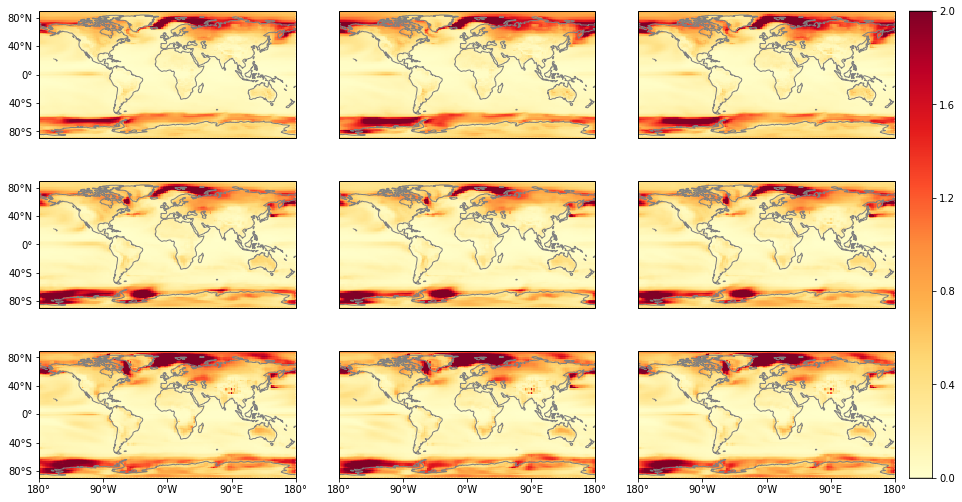

In [14]:
SNR  = 0.4
cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_0.0.npy')
plt_var(cdd)
plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/map_'+str(SNR)+'.png',bbox_inches='tight',dpi=300)


#SNR  = 100.0
#cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_SNR_100.0_locrad_0.0.npy')
#title = 'SNR = '+str(SNR)
#plt_rmse(cdd,title)
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/pt_figs/basic_'+str(SNR)+'.png',bbox_inches='tight',dpi=300)
#plt.show()

# Plot zonal means

0
CCSM4
CCSM4
1
MPI-ESM
CCSM4
2
HadCM3
CCSM4


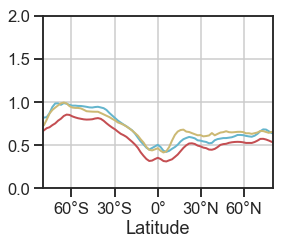

CCSM4
CCSM4
MPI-ESM
CCSM4
HadCM3
CCSM4


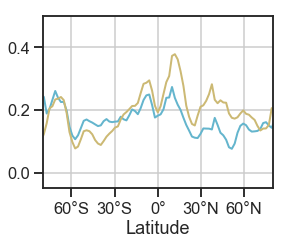

3
CCSM4
MPI-ESM
4
MPI-ESM
MPI-ESM
5
HadCM3
MPI-ESM


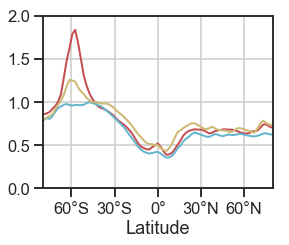

MPI-ESM
MPI-ESM
CCSM4
MPI-ESM
HadCM3
MPI-ESM


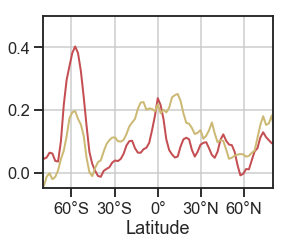

6
CCSM4
HadCM3
7
MPI-ESM
HadCM3
8
HadCM3
HadCM3


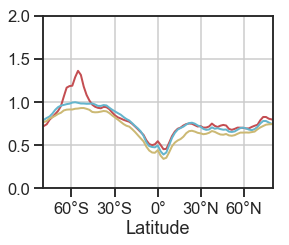

HadCM3
HadCM3
CCSM4
HadCM3
MPI-ESM
HadCM3


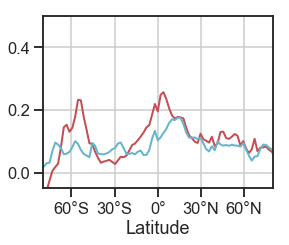

In [247]:
# Same but now normalized by variance in truth
# Zonal means plot

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

SNR = '0.4'

cdd4 = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_0.0.npy')
Xd   = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_0.0_ad.npy')

# Compute a grand ensemble truth mean
#Xdmv = np.mean(np.var(Xd,2),0).reshape([91,180])

lat = cdd4[0]['grid'].lat[:,0]

# This is an array of the results I want to plot. Each column appears on a plot. 
key = np.array([[0,3,6],[1,4,7],[2,5,8]])

# identify which is the truth-truth pair in each column
ttkey = np.array([0,1,2])

colkey = ['r','c','y']
rr = np.empty(2)

for ii in np.arange(3):
    fig = plt.figure(figsize=(4,3.))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    # List of cdd elements appearing in this plot
    keyii = key[:,ii]
    
    # Compute truth variance averaged over the three different realizations
    Xdmv = np.mean(np.var(Xd[keyii,:,:],2),0).reshape([91,180])
        
    for jj in np.arange(3):
        
        # Option to normalize by each truth variance. This can skew results, hence using the above singular scaling factor.
        #Xdmv = np.var(Xd[keyii[jj],:,:],1).reshape([91,180])

        plt.plot(lat,np.mean(cdd4[keyii[jj]]['rmse'].reshape([91,180])**2/Xdmv,1),
                 colkey[jj],linewidth=2)
        print(keyii[jj])
        print(cdd4[keyii[jj]]['prior_name'])
        print(cdd4[keyii[jj]]['truth_name'])
        
    #plt.ylabel('Zonal mean error variance\nfraction (scaled)')
    plt.ylim([0,2.0])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')

    #lgd = plt.legend([cdd4[keyii[0]]['prior_name'],
    #            cdd4[keyii[1]]['prior_name'],
    #            cdd4[keyii[2]]['prior_name']],
    #            bbox_to_anchor=(1., -.3),frameon=True,ncol=3)
    plt.xticks([-60,-30,0,30,60])
    ax.set_xticklabels(['60°S','30°S','0°','30°N','60°N'])
    plt.grid(axis='both')  
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/Prelims/zonmean_'+cdd4[keyii[0]]['truth_name']+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    
    # Now plot the fraction of error attributed to structural error
    
    # Define indices that aren't truth-truth pairs
    not_tt = [x for i,x in enumerate(np.array([0,1,2])) if x!=ttkey[ii]]
    
    # Truth - truth case
    ttr  = np.mean(cdd4[keyii[ttkey[ii]]]['rmse'].reshape([91,180])**2,1)
    print(cdd4[keyii[ttkey[ii]]]['prior_name'])
    print(cdd4[keyii[ttkey[ii]]]['truth_name'])

    # Cases where prior is not the same as truth
    rr0  = np.mean(cdd4[keyii[not_tt[0]]]['rmse'].reshape([91,180])**2,1)
    print(cdd4[keyii[not_tt[0]]]['prior_name'])
    print(cdd4[keyii[not_tt[0]]]['truth_name'])
    
    rr1  = np.mean(cdd4[keyii[not_tt[1]]]['rmse'].reshape([91,180])**2,1)
    print(cdd4[keyii[not_tt[1]]]['prior_name'])
    print(cdd4[keyii[not_tt[1]]]['truth_name'])
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.plot(lat,(rr0-ttr)/rr0,colkey[not_tt[0]],linewidth=2)
    plt.plot(lat,(rr1-ttr)/rr1,colkey[not_tt[1]],linewidth=2)

    #plt.ylabel('Zonal mean\nfraction of error\ndue to prior')
    plt.ylim([-0.05,0.5])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    plt.xticks([-60,-30,0,30,60])
    ax.set_xticklabels(['60°S','30°S','0°','30°N','60°N'])
    plt.grid(axis='both')  
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/Prelims/zonmean_frac_'+cdd4[keyii[0]]['truth_name']+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()


0
CCSM4
CCSM4
1
MPI-ESM
CCSM4
2
HadCM3
CCSM4


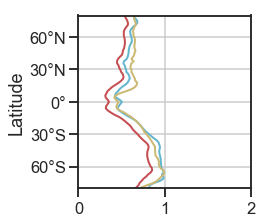

CCSM4
CCSM4
MPI-ESM
CCSM4
HadCM3
CCSM4


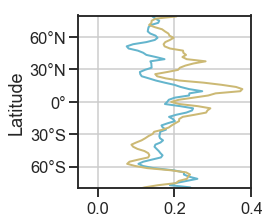

3
CCSM4
MPI-ESM
4
MPI-ESM
MPI-ESM
5
HadCM3
MPI-ESM


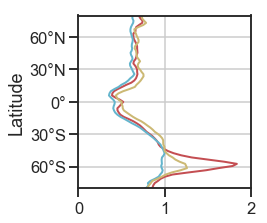

MPI-ESM
MPI-ESM
CCSM4
MPI-ESM
HadCM3
MPI-ESM


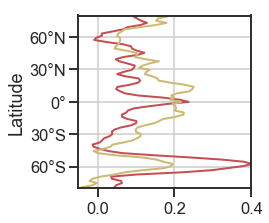

6
CCSM4
HadCM3
7
MPI-ESM
HadCM3
8
HadCM3
HadCM3


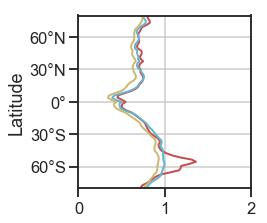

HadCM3
HadCM3
CCSM4
HadCM3
MPI-ESM
HadCM3


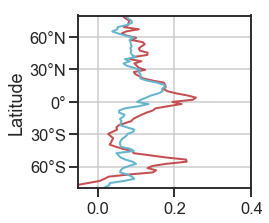

In [259]:
# Same but now normalized by variance in truth
# ... and turned sideways
# Zonal means plot

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

SNR = '0.4'

#cdd4 = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_0.0.npy')
#Xd   = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_0.0_ad.npy')

# Compute a grand ensemble truth mean
#Xdmv = np.mean(np.var(Xd,2),0).reshape([91,180])

lat = cdd4[0]['grid'].lat[:,0]

# This is an array of the results I want to plot. Each column appears on a plot. 
key = np.array([[0,3,6],[1,4,7],[2,5,8]])

# identify which is the truth-truth pair in each column
ttkey = np.array([0,1,2])

colkey = ['r','c','y']
rr = np.empty(2)

for ii in np.arange(3):
    fig = plt.figure(figsize=(3,3.))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    # List of cdd elements appearing in this plot
    keyii = key[:,ii]
    
    # Compute truth variance averaged over the three different realizations
    Xdmv = np.mean(np.var(Xd[keyii,:,:],2),0).reshape([91,180])
        
    for jj in np.arange(3):
        
        # Option to normalize by each truth variance. This can skew results, hence using the above singular scaling factor.
        #Xdmv = np.var(Xd[keyii[jj],:,:],1).reshape([91,180])

        plt.plot(np.mean(cdd4[keyii[jj]]['rmse'].reshape([91,180])**2/Xdmv,1),lat,
                 colkey[jj],linewidth=2)
        print(keyii[jj])
        print(cdd4[keyii[jj]]['prior_name'])
        print(cdd4[keyii[jj]]['truth_name'])
        
    #plt.ylabel('Zonal mean error variance\nfraction (scaled)')
    plt.xlim([0,2.0])
    plt.ylim([-80,80])
    plt.ylabel('Latitude')

    #lgd = plt.legend([cdd4[keyii[0]]['prior_name'],
    #            cdd4[keyii[1]]['prior_name'],
    #            cdd4[keyii[2]]['prior_name']],
    #            bbox_to_anchor=(1., -.3),frameon=True,ncol=3)
    plt.yticks([-60,-30,0,30,60])
    ax.set_yticklabels(['60°S','30°S','0°','30°N','60°N'])
    plt.grid(axis='both')  
    # plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/Prelims/zonmean_'+cdd4[keyii[0]]['truth_name']+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    
    # Now plot the fraction of error attributed to structural error
    
    # Define indices that aren't truth-truth pairs
    not_tt = [x for i,x in enumerate(np.array([0,1,2])) if x!=ttkey[ii]]
    
    # Truth - truth case
    ttr  = np.mean(cdd4[keyii[ttkey[ii]]]['rmse'].reshape([91,180])**2,1)
    print(cdd4[keyii[ttkey[ii]]]['prior_name'])
    print(cdd4[keyii[ttkey[ii]]]['truth_name'])

    # Cases where prior is not the same as truth
    rr0  = np.mean(cdd4[keyii[not_tt[0]]]['rmse'].reshape([91,180])**2,1)
    print(cdd4[keyii[not_tt[0]]]['prior_name'])
    print(cdd4[keyii[not_tt[0]]]['truth_name'])
    
    rr1  = np.mean(cdd4[keyii[not_tt[1]]]['rmse'].reshape([91,180])**2,1)
    print(cdd4[keyii[not_tt[1]]]['prior_name'])
    print(cdd4[keyii[not_tt[1]]]['truth_name'])
    
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.plot((rr0-ttr)/rr0,lat,colkey[not_tt[0]],linewidth=2)
    plt.plot((rr1-ttr)/rr1,lat,colkey[not_tt[1]],linewidth=2)

    #plt.ylabel('Zonal mean\nfraction of error\ndue to prior')
    plt.xlim([-0.05,0.4])
    plt.ylim([-80,80])
    plt.ylabel('Latitude')
    plt.yticks([-60,-30,0,30,60])
    ax.set_yticklabels(['60°S','30°S','0°','30°N','60°N'])
    plt.grid(axis='both')  
    # plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/Prelims/zonmean_frac_'+cdd4[keyii[0]]['truth_name']+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()


# Create swarm plots showing sensitivity to localization

In [80]:
# Create pandas dataframe to use in swarm plot

SNR = '0.4'
LOCRADs = ['0.0','25000.0','10000.0','5000.0','2000.0']

gmp = pd.DataFrame(columns=['gmv','LOCRAD','LOCind','prior_name','truth_name'])

for ii,LOCRAD in enumerate(LOCRADs):

    cdd4 = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_'+LOCRAD+'.npy')
    lat = cdd4[0]['grid'].lat

    for jj in np.arange(len(cdd4)):

        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))
        ne = [gm,LOCRAD,cdd4[jj]['prior_name'],cdd4[jj]['truth_name']]
#                          ,columns=['gmv','LOCRAD','prior_name','truth_name'])
        nee = pd.DataFrame({"gmv":[gm],
                            "LOCRAD":LOCRAD,
                            "LOCind":ii,
                            "prior_name":cdd4[jj]['prior_name'],
                            "truth_name":cdd4[jj]['truth_name']                            
                           })
        gmp=gmp.append(nee)




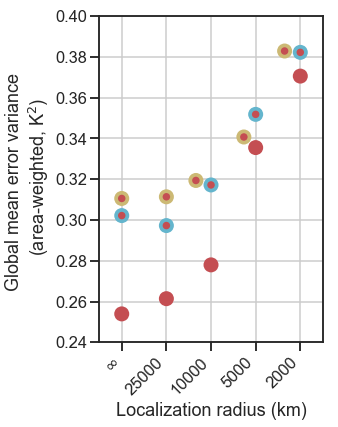

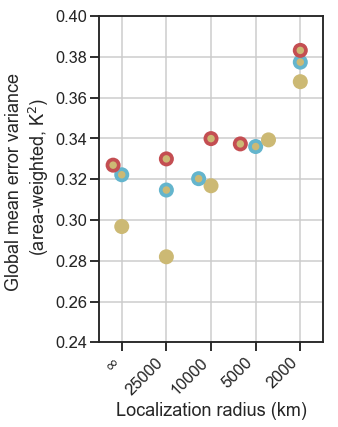

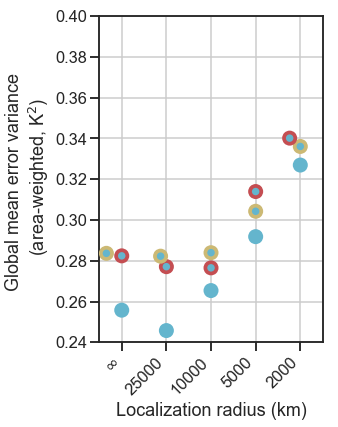

In [111]:
sns.set(style='ticks', context='talk')

gmp1 = gmp[gmp['truth_name']=='CCSM4']
plotswarm(gmp1,"r")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/prelims/gm_rmse_gumball_CCSM4.pdf', bbox_inches='tight')

gmp2 = gmp[gmp['truth_name']=='HadCM3']
plotswarm(gmp2,"y")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/prelims/gm_rmse_gumball_HADCM3.pdf', bbox_inches='tight')

gmp3 = gmp[gmp['truth_name']=='MPI-ESM']
plotswarm(gmp3,"c")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/prelims/gm_rmse_gumball_MPI-ESM.pdf', bbox_inches='tight')

# Create swarm plots showing regional mean errors

In [78]:
# Compute regional means for the random draws case.

# Construct regional averages. These were EYEBALLED from the PAGES 2k paper.
# Arctic: >60
# Antarctic: >60
# N America: 30-55 N, 135-75 W
# S America: 66-20 S, 82-37 W
# Europe: 37 - 70 N, 7W - 40 E
# Asia: 23-47 N, 60-165E
# Australasia: 50-0S, 120-180 E

SNR = 0.4
LOCRAD = 0.0

# Now for random draws
cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_' + str(LOCRAD)+'.npy')
Xd  = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_300_rand_draws_redo_for_ad_locrad_' + str(LOCRAD)+'_ad.npy')

# Compute a grand ensemble truth mean
Xdmv = np.mean(np.var(Xd,2),0)

lats = cdd[0]['grid'].lat
lons = cdd[0]['grid'].lon
nlat = cdd[0]['grid'].nlat
nlon = cdd[0]['grid'].nlon
Inf = np.inf

# Mins and maxes defined looking from left to right on the globe
regnames = ['NH','SH','Arctic', 'Antarctic','N. America','S. America','Europe','Asia','Australasia','Global']
reglatmins = [0,-Inf,60, -Inf,30,-66,37,23,-50,-Inf]
reglatmaxs = [Inf,0,Inf, -60,55,-20,70,47,0,Inf]
reglonmins = [-Inf,-Inf,-Inf, -Inf,225,278,353,60,120,-Inf]
reglonmaxs = [Inf,Inf,Inf, Inf,285,323,40,165,180,Inf]

wtmaps = np.tile(np.nan*np.ones([nlat,nlon]),[len(regnames),1,1])
allmap_std_ps = np.nan*np.ones([nlat,nlon])

std_ps = np.nan*np.ones([len(cdd),len(regnames)])

gmpl = pd.DataFrame(columns=['errvar','region','prior_name','truth_name','regind'])
gmps = pd.DataFrame(columns=['errvar','region','prior_name','truth_name','regind'])

# indices of regions with relatively large and small error variances. Separating for plotting.
leri = np.array([2,3,4,5,6])
seri = np.array([0,1,7,8,9])


for jj in np.arange(len(regnames)):
    for ii in np.arange(len(cdd)):
        
        fp    = cdd[ii]['recon']
        
        # Define the region
        wtmap = np.nan*np.ones([nlat,nlon])
        
        if reglonmins[jj]>reglonmaxs[jj]:
            sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & ((lons>reglonmins[jj]) | (lons<=reglonmaxs[jj]))
        else:
            sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & (lons>reglonmins[jj]) & (lons<=reglonmaxs[jj])
        lwm = np.cos(.5*np.pi*lats[sh]/180)
        wt1 = lwm

        # Straight "truth" estimate:
        m_st = np.dot(wt1.T/np.sum(wt1),Xd[ii,:,:][sh.ravel(),:])

        # Straight "prior" estimate:
        m_sp = np.dot(wt1.T/np.sum(wt1),fp[sh.ravel(),:])

        # For normalizing
        n_st = np.dot(wt1.T/np.sum(wt1),Xdmv[sh.ravel()])
        
        nee = pd.DataFrame({"errvar":[np.var(m_sp-m_st)],
                    "wtd_errvar":[np.var(m_sp-m_st)/n_st],
                    "region":regnames[jj],
                    "prior_name":cdd[ii]['prior_name'],
                    "truth_name":cdd[ii]['truth_name'],
                    "regind":jj
                   })
        
        if any(leri==jj):
            gmpl=gmpl.append(nee)
        else:
            gmps=gmps.append(nee)
                                                        

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


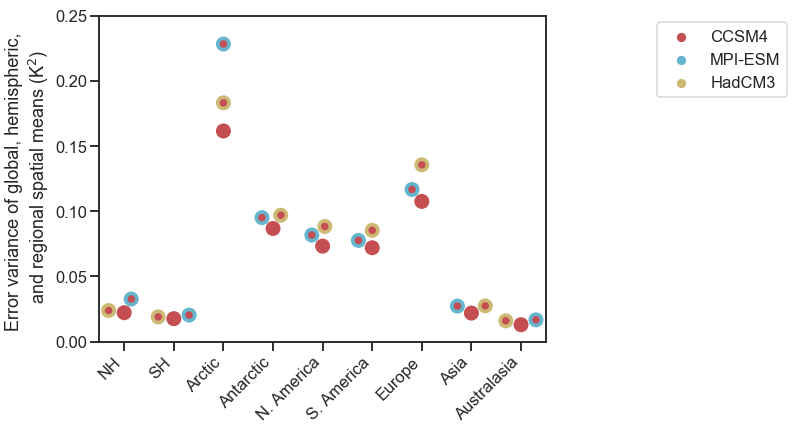

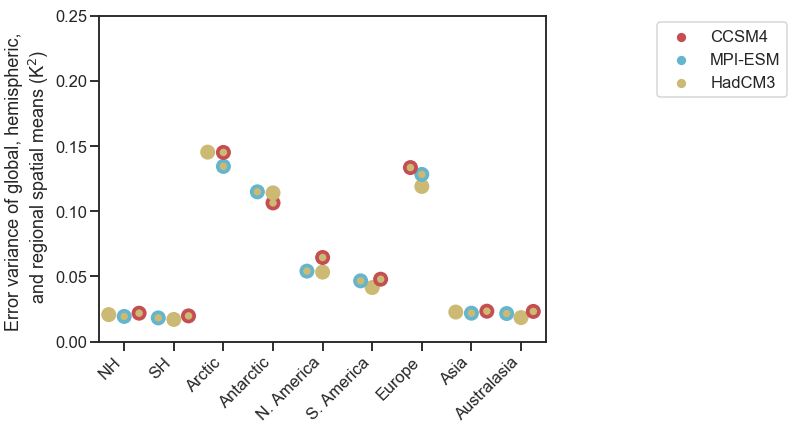

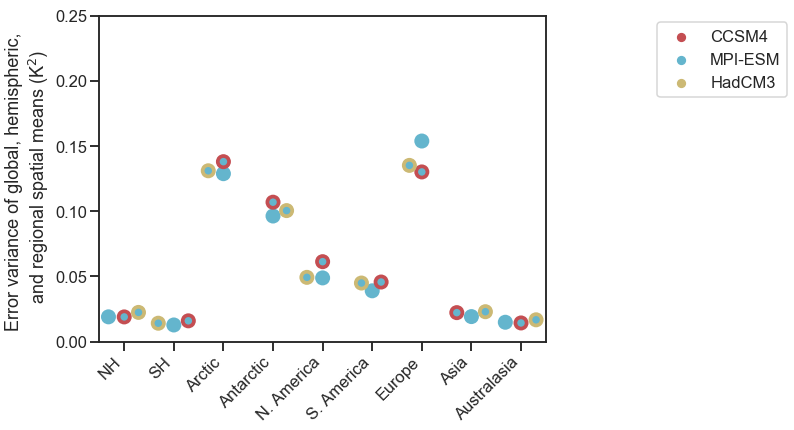

In [13]:
sns.set(style='ticks', context='talk')

gmp1 = gmp[gmp['truth_name']=='CCSM4']
plot_reg_swarm(gmp1,"r")

gmp2 = gmp[gmp['truth_name']=='HadCM3']
plot_reg_swarm(gmp2,"y")

gmp3 = gmp[gmp['truth_name']=='MPI-ESM']
plot_reg_swarm(gmp3,"c")

TypeError: plot_reg_swarm2() takes 1 positional argument but 2 were given

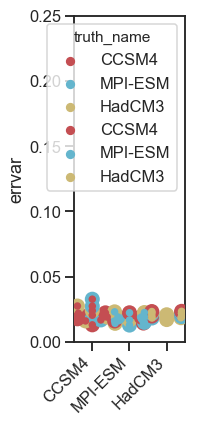

In [43]:
sns.set(style='ticks', context='talk')

gmp1 = gmp[gmp['truth_name']=='CCSM4']
plot_reg_swarm3(gmps)

gmp2 = gmp[gmp['truth_name']=='HadCM3']
plot_reg_swarm3(gmpl)


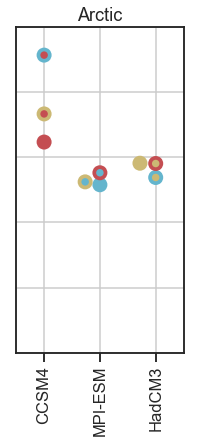

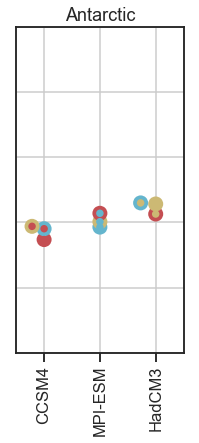

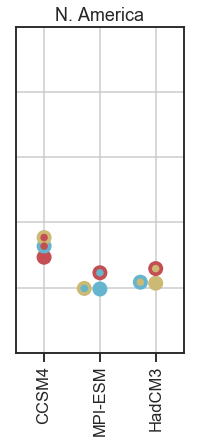

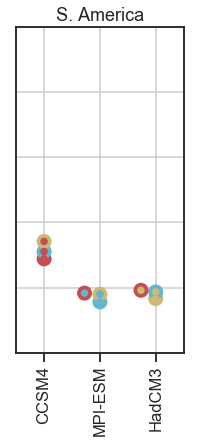

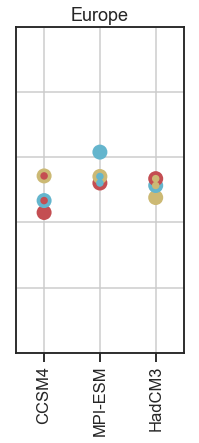

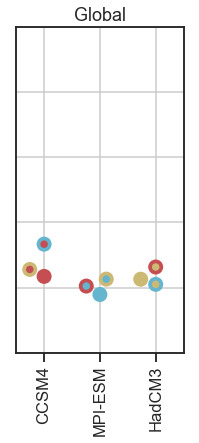

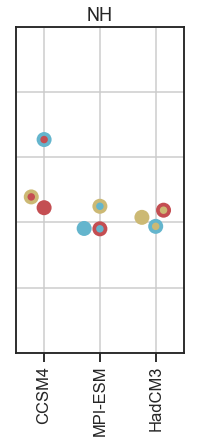

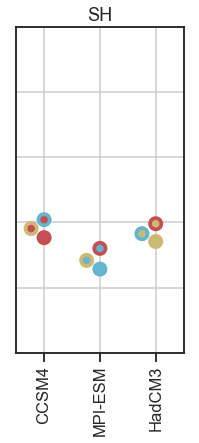

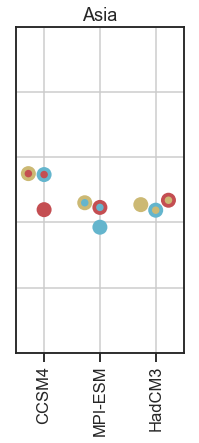

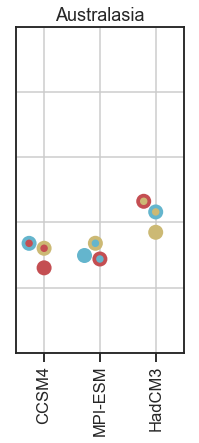

In [98]:
sns.set(style='ticks', context='talk')

regnamesl = ['Arctic', 'Antarctic','N. America','S. America','Europe']
regnamess = ['Global','NH','SH','Asia','Australasia']

for rn in enumerate(regnamesl):
    gmp1 = gmpl[gmpl['region']==rn[1]]
    plot_reg_swarm2(gmp1,0.25)
    plt.title(rn[1])
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/reg_avg_'+rn[1]+'.pdf',bbox_inches = "tight")
    
for rn in enumerate(regnamess):
    gmp1 = gmps[gmps['region']==rn[1]]
    plot_reg_swarm2(gmp1,0.05)
    plt.title(rn[1])
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/reg_avg_'+rn[1]+'.pdf',bbox_inches = "tight")


In [57]:
# Load and interpolate all of the priors I want to use as truth
# NB that this is just for grids etc. for now... everything else is stored in files that must be loaded.

lmr_names = ['ccsm4_last_millenium.300',
             'mpi-esm-p_last_millenium.300',
             'hadcm3_last_millenium.300']
model_names = ['CCSM4','MPI-ESM','HadCM3']

ad=mk_ad(lmr_names,model_names)

Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 300 ensemble members
regridding prior...
0 55295
(55296, 300)
(55296, 2)
(55296, 2)
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
nlat,nlon: 192 288
=> Full array:      -9.229859352111816 8.361244201660156 0.018513596478727943 0.8100177314487885
=> Truncated array: -9.0365372796429 8.30

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


20.60874374735625


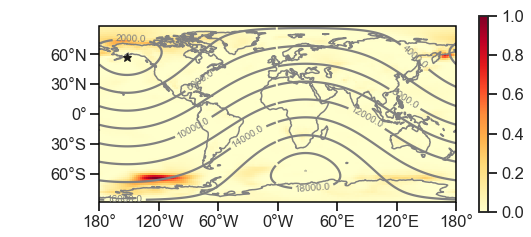

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater_equal
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/nu

210.6282301909216


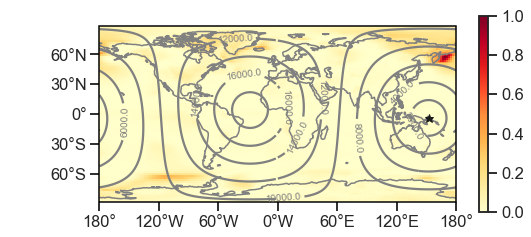

In [63]:
drange,r0 = mkresplot(ad,141)
plt.show()
drange,r1 = mkresplot(ad,418) # eq
plt.show()

In [ ]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

plt.figure(figsize=(8,4))
plt.plot(drange[:-1],np.array(r0)/np.nanmax(np.array(r0)))
plt.plot(drange[:-1],np.array(r1)/np.nanmax(np.array(r1)))
#plt.plot(drange[:-1],np.array(r2))
plt.ylabel('Total squared regression\nerror (normalized)')
plt.xlabel('Distance from observation (km)')
plt.xlim([0,20000])
plt.ylim([-.1,1.3])
plt.legend(['High-latitude site (a)', 'Tropical site (b)'],
           frameon=False,loc='upper left',ncol=2)
plt.tight_layout
plt.savefig('/Users/dan/Desktop/Nullspace_Figs2/reg_error_rad.pdf')
plt.show()